# Scenario 1

## Task 1

Data Gathering and Pre-processing


API connection and data extraction from the data source


In [24]:
# !pip install -r requirements.txt
# Scenario 1/2 Imports
import csv
import glob
import os
import re
import datetime
from datetime import date
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly
import requests
import seaborn as sns
import tweepy
import plotly.graph_objects as go # we can not use express plots
from plotly.subplots import make_subplots # creating subplots

from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.graph_objects as go
import pyprojroot
os.chdir(pyprojroot.here())

# Global variables
graph_style = "ggplot"
graph_size = (25, 15)
number_of_tweets = 300


In [19]:
def get_twitter_auth():
    # Access
    api_key = "cW0baXByVgPOTGYxtMJemj4oZ"
    api_secret = "ktRwML34E5fniXClpSqnXkFytkOTFCZdS9sTM5LcaRY87WnP1K"
    access_token = "1448619504293060609-eMsiWzCxjCp6PBD6c7qCA7yfWNjIHV"
    access_token_secret = "yH5tunDKqchrb912RP2bH78mKGrLqnm9nh1ccLbF49RUD"

    auth = tweepy.OAuthHandler(api_key, api_secret)
    auth.set_access_token(access_token, access_token_secret)

    return tweepy.API(auth, wait_on_rate_limit=True)


def read_twitter_data(usernames: list) -> pd.DataFrame():
    """Reads generated or file-saved twitter data to dataframe

    Args:
        profiles (list): list of the main user profiles we want to read data for

    Returns:
        pd.DataFrame: tweet data for each user in 'profiles' list
    """
    df = pd.DataFrame()
    # If the file already exists, load it to a dataframe
    if generate_twitter_data is False or Path(file_path).is_file():
        # If the file exists
        if Path(file_path).is_file():
            # print("Reading twitter data from file")
            # Read the data file in
            tempdf = pd.read_csv("data/twitter_data.csv")
            # Remove title row
            tempdf = tempdf[tempdf["user"] != "user"]
            dataframes = []
            for name in usernames:
                if tempdf[tempdf["user"] == name].shape[0] == 0:
                    tempdf = get_multiple_user_twitter_data([name], 300)

                dataframes.append(tempdf[tempdf["user"] == name])
            df = pd.concat(dataframes)
            # If the data for this user doesn't already exist
            # display(df)
    else:
        # print("File doesn't exist, generating data")
        # Get 300 tweets for each user
        df = get_multiple_user_twitter_data(usernames, 300)

    return df


def get_multiple_user_twitter_data(names: list, n: int) -> pd.DataFrame():
    """Gets twitter data of each user in the list of names provided

    Args:
        names (str): list of main user names
        n (int): number of tweets we want to collect

    Returns:
        pd.DataFrame: Dataframe of main user tweet data with n tweets for each user
    """
    headers = True
    df = pd.DataFrame()

    for name in names:
        # Create dataframe with this list data
        temp = get_single_user_twitter_data(name, n)
        temp["user"] = name
        # append data to csv
        temp.to_csv(file_path, mode="a", header=headers, index=False)
        df = df.append(temp)
        headers = False

    return df


def get_single_user_twitter_data(name: str, n: int) -> pd.DataFrame():
    """Gets n numbers of tweets, likes and the created time of those tweets for user provided through

    Args:
        name (str): name of user
        n (int): number of tweets we want to collect data from

    Returns:
        pd.DataFrame : dataframe with all relevant twitter data
    """
    tweets = []
    likes = []
    time = []
    retweets = []
    lng = []
    lat = []
    create_time = []

    for i in tweepy.Cursor(
        api.user_timeline, screen_name=name, tweet_mode="extended"
    ).items(n):
        latitude = None
        longitude = None
        tweets.append(i.full_text)
        likes.append(i.favorite_count)
        time.append(i.created_at)
        retweets.append(i.retweet_count)
        create_time.append(i.created_at)
        if i.place is not None:
            coords = i.geo["coordinates"]
            latitude = coords[0]
            longitude = coords[1]
        lat.append(latitude)
        lng.append(longitude)

    df = pd.DataFrame(
        {
            "create_time": create_time,
            "tweets": tweets,
            "likes": likes,
            "retweets": retweets,
            "time": time,
            "latitude": lat,
            "longitude": lng,
        }
    )

    return df


def get_user_followers(name: str) -> int():
    """Extracts a user's followers

    Args:
        name (str): name of the user

    Returns:
        int: User's number of followers
    """
    return int(api.get_user(screen_name=name).followers_count)


def get_user_tweets(name: str, n: int) -> list():
    """Gets the user's tweets
    Args:
        n (int): Number of tweets to collect
        name (str): name of user

    Returns:
        list: list of tweets for user
    """
    temp = read_twitter_data([name])
    tweets = temp["tweets"].tolist()
    return tweets


def get_user_mentions_by_user(user: str, data: pd.DataFrame()) -> pd.DataFrame():
    """Gets a list of users mentioned throughout user's tweets
    Args:
        user (str): The user we want to get information from
        data (pd.DataFrame): The data we're extracting the usernames from

    Returns:
        pd.DataFrame: The dataframe containing the mentioned usernames in the tweets and the number of times each name has been mentioned
    """

    # Filter data by user
    tempdf = data.loc[data["user"] == user]
    # Filter data to only contain rows with @ symbols in tweets
    tempdf = tempdf[tempdf.tweets.str.contains("@")]
    return tempdf


def get_top_n_tweets(users: list, n: int) -> pd.DataFrame():
    """Gets the top n tweets for each user

    Args:
        users (list): List of users we want to retrieve tweets from
        n (int): Number of tweets we want to retrieve

    Returns:
        pd.DataFrame(): Dataframe containing tweet data for each user in users
    """
    # Get a single users tweets
    data = read_twitter_data(users)
    df = pd.DataFrame()
    for user in users:
        temp = data[data["user"] == user]
        temp = temp.sort_values(by="likes", ascending=False)
        df = df.append(temp[:n])
    # Sort the dataframe by favourite/like count (metric to define popularity)
    # data = data.sort_values(by='likes', ascending = False)
    # Remove everything except first n get_top_n_tweets
    n = n * len(users)
    data = df[:n]
    # Return n tweets
    return data


def get_top_n_retweeted_tweets(users: list, n: int) -> pd.DataFrame():
    """Get the top quantity of tweets each user has that received the most retweets.
    This removes any tweets the user hasn't made themselves (Tweets they've retweeted themselves)
    Args:
        users (list): the users we want to check for retweet counts
        n (int): top number of tweets for each user

    Returns:
        pd.DataFrame: Dataframe containing top n retweeted tweets for each user
    """
    # Get users tweets
    data = read_twitter_data(users)
    # Remove retweets from dataframe for every user
    data = remove_retweeted_tweets(data)

    df = pd.DataFrame()
    for user in users:
        temp = data[data["user"] == user]
        # Sort the dataframe by retweet count (metric to define popularity)
        temp = temp.sort_values(by="retweets", ascending=False)
        # Append n tweets (Should be the most retweeted tweets after sorting)
        df = df.append(temp[:n])
    n = n * len(users)
    # Remove everything except first n get_top_n_tweets
    data = df[:n]
    # Return n tweets
    return data


# Plot functions
def plot_sum_of_likes_per_user(data):
    # Retrieve each unique username
    for user in df["user"].unique():
        tweets = df[df["user"] == user]
        total_likes = tweets["likes"].sum()
        plt.bar(x=tweets["user"], height=total_likes, width=0.6)
    plt.title("Sum of likes per user")
    plt.xlabel("Users")
    plt.ylabel("Likes")
    plt.show()


def plot_likes_for_tweets_over_time(data):
    users = df["user"].unique()
    print(users)
    fig, ax = plt.subplots(nrows=int(len(users) / 2), ncols=2, figsize=graph_size)
    i = 0
    j = 0
    count = 0
    for user in users:
        tweets = df[df["user"] == user]
        # print(j, i, count)
        ax[j, i].bar(tweets["time"], tweets["likes"], label=user)
        if i < 1:
            i += 1
        else:
            i = 0
            j += 1
    print(tweets["likes"].min(), tweets["likes"].max())
    plt.xticks(np.arange(tweets["likes"].min(), tweets["likes"].max(), 10000))
    plt.show()


# Remove function(s)
def remove_retweeted_tweets(data):
    return data[~data.tweets.str.contains("RT")]


# Working on function here
def clean_tweet_data(tweet: str) -> str():
    """Cleans the tweet's text of clutter

    Args:
        tweet (str): tweet text

    Returns:
        str: the cleaned/refined tweet text
    """
    # Removes any @mentions
    tweet = re.sub(r"@[A-Za-z0-9]+", "", tweet)
    # Remove hashtags (# symbols)
    tweet = re.sub(r"#", "", tweet)
    # Remove retweet indicator, 'RT' from tweet text
    tweet = re.sub(r"RT[\s]+", "", tweet)
    # Remove urls from the tweet
    tweet = re.sub(r"https?:\/\/\S+", "", tweet)
    return tweet


def drop_null_location_rows(data: pd.DataFrame) -> pd.DataFrame():
    """Drops all rows in dataframe without long/lat values

    Args:
        data (pd.DataFrame): twitter data

    Returns:
        pd.DataFrame: twitter data purged of all rows with null location values
    """
    # Replace empty tweet strings to nan objects
    data["tweets"].replace("", np.nan, inplace=True)
    # Drop all rows with nan objects
    data = data.dropna()
    return data


# Misc functions
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i] // 2, y[i], ha="center", fontsize="xx-large")
        

def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity


def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity


Initialise user profile names, api and get the necessary twitter data from functions I've made.


In [4]:
generate_twitter_data = True
twitter_data_file_exists = False

file_dir = os.path.abspath("")
file_path = os.path.join(file_dir, "data/twitter_data.csv")


# Names of the users we want to analyse
names = ["KSI", "miniminter", "Behzinga"]

# Get api twitter authenticated
api = get_twitter_auth()
api.verify_credentials()


# Get twitter data
df = read_twitter_data(names)
print(str(df.shape[0]) + " tweets\t" + str(df.shape[1]) + " columns")
# Fills nan values for columns to 0
# df['latitude'].fillna(0, inplace = True)
# df['longitude'].fillna(0, inplace = True)
for user in names:
    print(f"{user} has {df[df['user'] == user].shape[0]} tweets")


900 tweets	8 columns
KSI has 300 tweets
miniminter has 300 tweets
Behzinga has 300 tweets


Data Pre-processing from the data source to transform the original data into a Pandas dataframe


Perform a data cleansing activity considered relevant for the process (if any)


Provide the explanation of the process, the justification behind it, lessons learned and findings.


# Task 2 - Exploratory Data Analysis


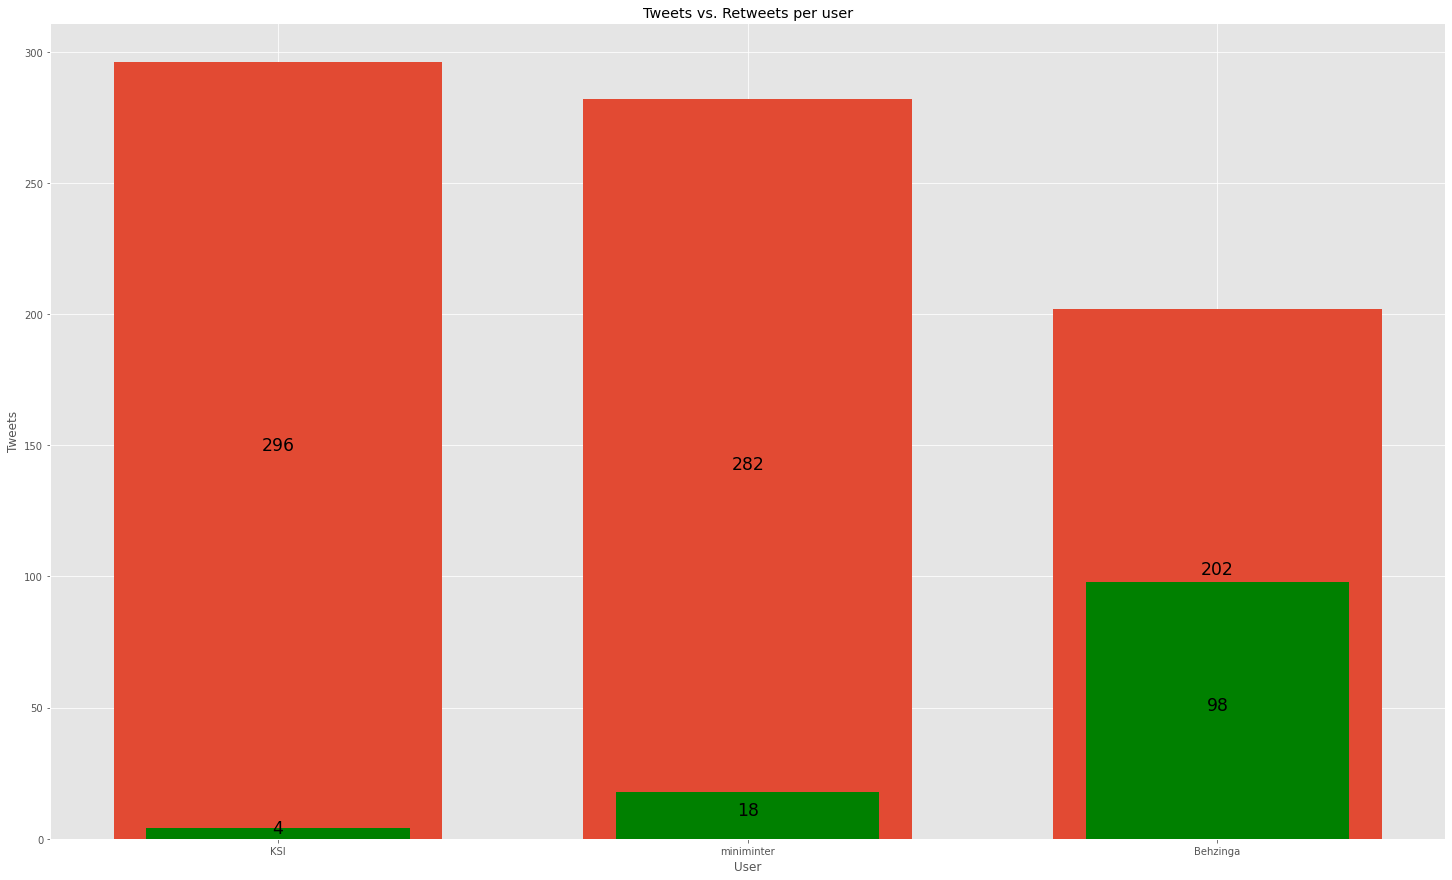

In [5]:
def tweets_vs_retweets(names):
    # Original tweets vs Retweets
    original_tweet_count = []
    df_copy = df.copy()
    # Calculate total number of tweets per user
    for user in names:
        tempdf = df_copy[df_copy["user"] == user]
        original_tweet_count.append(len(tempdf.index))

    # Remove retweets from dataframe for every user
    df_copy = df_copy[~df_copy.tweets.str.contains("RT")]

    new_tweet_count = []
    # Calculate new number of tweets per user
    for user in names:
        tempdf = df_copy[df_copy["user"] == user]
        new_tweet_count.append(len(tempdf.index))

    # Calculate number of retweets
    retweets = []
    zip_object = zip(original_tweet_count, new_tweet_count)
    for list1_i, list2_i in zip_object:
        retweets.append(list1_i - list2_i)

    # Plot the data to a bar chart
    width = 0.7
    indices = np.arange(len(new_tweet_count))

    plt.figure(figsize=graph_size)
    plt.style.use(graph_style)
    plt.bar(indices, new_tweet_count, width=width, label="Original Tweets")
    addlabels(indices, new_tweet_count)
    plt.bar(
        [i + 0.25 * width - width / 4 for i in indices],
        retweets,
        width=0.8 * width,
        color="g",
        label="Retweets",
    )
    addlabels([i + 0.25 * width - width / 4 for i in indices], retweets)

    plt.title("Tweets vs. Retweets per user")
    plt.xlabel("User")
    plt.ylabel("Tweets")
    plt.xticks(indices + width / 2 - width / 2, names)
    plt.show()

tweets_vs_retweets(names)


In [20]:
def plot_followers_per_user(names):
    """Plot number of followers per user

    Args:
        names (list): list of names to find and plot followers for
    """
    x = names
    y = []
    y_text = []
    # For each unique user
    for user in names:
        # Get the total number of followers for this user
        followers = get_user_followers(user)
        y.append(followers)
        y_text.append(f"{followers:,} followers")
    
    fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y_text,
            textposition='auto',
        )],
        layout = go.Layout(
            xaxis = dict(
                title = "Users"
            ),
            yaxis = dict(
                title = "Followers"
            ),
            title = dict(
                text = "Followers per user",
                x = 0.5
            )
        ))

    fig.show()


plot_followers_per_user(names)


In [77]:
def filter_dataframe_for_mentions(df):
    """Extracts mentions from tweets and appends them as a new column to the dataframe

    Args:
        df (pd.DataFrame): [description]

    Returns:
        pd.DataFrame: [description]
    """
    # List to store dataframes to list
    dataframes = []
    for user in df["user"].unique():
        # Retrieve mentions of users from main user tweets
        tweet_list = get_user_tweets(user, number_of_tweets)
        # Create template_dataframe storing name of the user and all their tweets
        tempdf = pd.DataFrame({"user": user, "tweets": tweet_list})
        # Get dataframe of user mentions (dataframe because we can retrieve the names from tweets)
        tempdf = get_user_mentions_by_user(user, tempdf)
        # Create new column 'mention' with names of users being mentioned in tweets
        tempdf["mention"] = tempdf.tweets.str.findall(r"(?<![@\w])@(\w{1,25})").apply(
            ",\n".join
        )
        # add the temporary dataframe for user 'name' to overall dataframe list
        this_one = mentions
        if this_one > tempdf.shape[0]:
            this_one = tempdf.shape[0]
        try:
            dataframes.append(tempdf.head(this_one))
        except Exception as e:
            print(tempdf.shape[0], this_one)
            print(e)

    # Create overall dataframe using all dataframes from list
    global_mention_df = pd.concat(dataframes)
    return global_mention_df


def standardise_mentions(df):
    """Attempts to standardise mentions
    So the same mentioned account isn't treated as 2 or more separate accounts due to case differences

    Args:
        df (pd.DataFrame): Twitter dataframe

    Returns:
        pd.DataFrame: Twitter dataframe with refined mentions column
    """
    df["mention"] = df["mention"].str.lower()
    return df


def expand_multiple_mentions(df):
    """Separates strings containing multiple mentions into their own rows.

    Args:
        df (pd.DataFrame): dataframe containing user mentions

    Returns:
        df: refined dataframe with one user mention per row
    """
    # df = df[df.mention]
    dataframes = []
    original_record_size = df.shape[0]
    df_copy = df.copy()
    for user in df["user"].unique():
        all_mentions = []
        user_mentions = df[df["user"] == user]
        for mention in user_mentions["mention"]:
            # Split several mentions in one string to list of mentions
            mentions = mention.split(",")
            mentions = [m.replace("\n", "") for m in mentions]
            # Append each mention to all mentions list
            [all_mentions.append(one_mention) for one_mention in mentions]
        refined_dataframe_1 = pd.DataFrame({"user": user, "mention": all_mentions})
        dataframes.append(refined_dataframe_1)
    # dataframes.append(df_copy)
    new = pd.concat(dataframes)
    # print(
    #     f"Data has been refined. {original_record_size} records to {new.shape[0]} records after separating the multiple mentions"
    # )
    return new


def condense_dataframe_add_user_count(df):
    """ Calculates number of instances a user is mentioned and appends this new value as a column to the condensed dataframe
    One row per mentioned user
    Args:
        df (pd.DataFrame): Dataframe containing mentions

    Returns:
        df: refined dataframe containing one row per mentioned user
    """
    dataframes = []
    for user in df["user"].unique():
        temp = df[df["user"] == user]
        # Get counts for each mention
        mention_counts = temp["mention"].value_counts()
        # Get names for each user from indices in counts
        mention_names = mention_counts.index.tolist()
        dataframes.append(
            pd.DataFrame(
                {
                    "user": user,
                    "mention": mention_names,
                    "count": mention_counts.tolist(),
                }
            )
        )
    overall_df = pd.concat(dataframes)
    return overall_df


# Are there any 'favourite' accounts mentioned by these users?
def plot_top_most_mentioned_users(df):
    """Retrieves the top most mentioned users from specific user profiles
    names, sum of names
    Args:
        names (list): list of user profiles we're deriving mention data from
    """
    fig = make_subplots(
        rows=3,
        cols=1,
    )
    for index, user in enumerate(names):
        # Calculate the number of mentions each account has by this user
        temp = df[df["user"] == user]
        mentions = temp["count"].tolist()[:10]
        # Retrieve each unique mentioned user from the list
        mentioned = temp["mention"].tolist()[:10]
        mentions_text = [f"{mention} mentions" for mention in mentions]
        fig.add_trace(
            go.Bar(
                x=mentioned,
                y=mentions,
                text=mentions_text,
                textposition="auto",
                name=user,
                showlegend=False,
            ),
            row=index + 1,
            col=1,
        )
    fig.update_layout(height=800, title=dict(text="Top mentioned users", x=0.5))
    fig.show()


df = read_twitter_data(names)
df = filter_dataframe_for_mentions(df)
df = standardise_mentions(df)
df = expand_multiple_mentions(df)
df = condense_dataframe_add_user_count(df)

plot_top_most_mentioned_users(df)


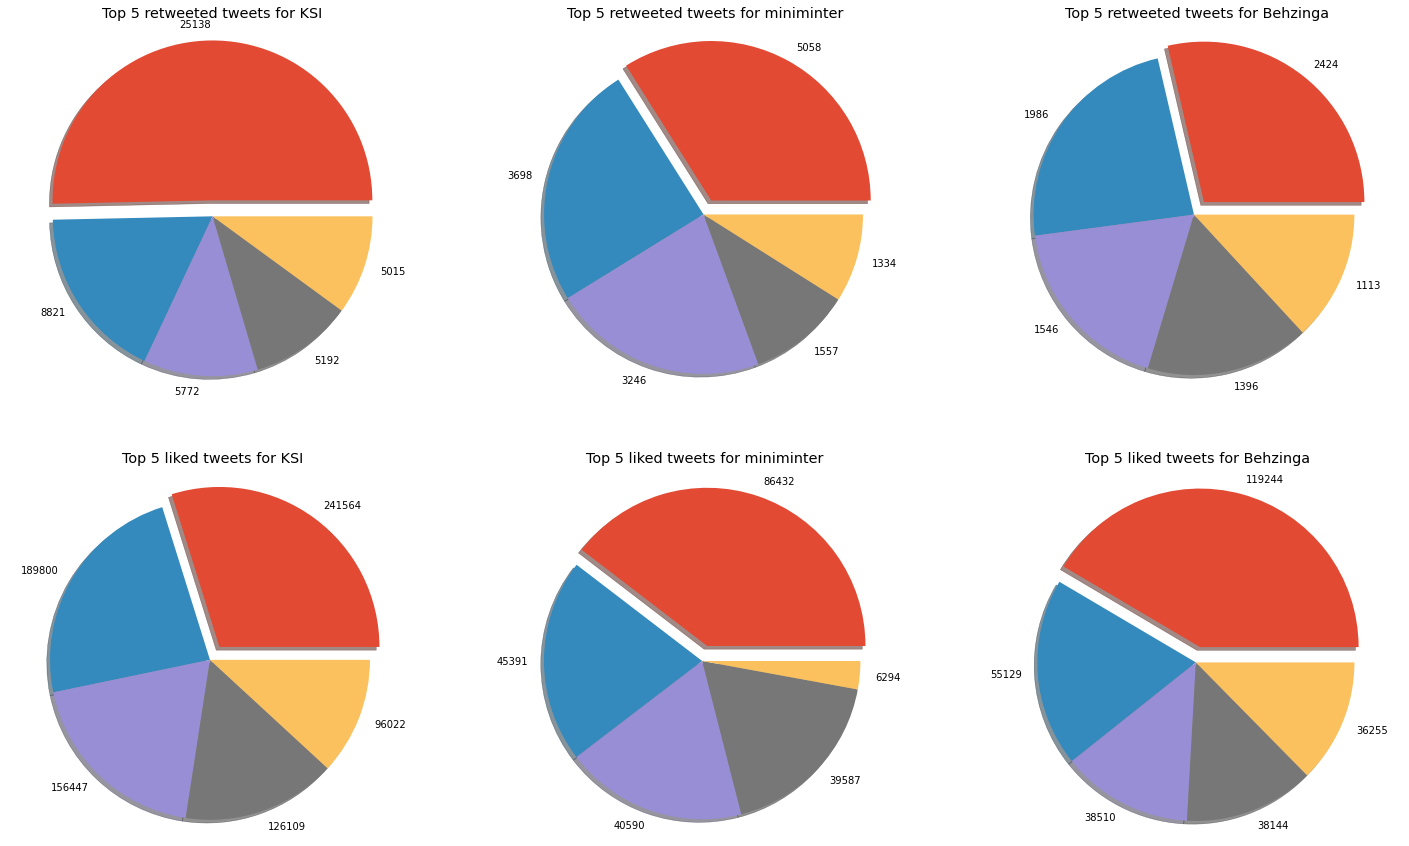

In [79]:
def plot_top_n_tweets(n=5, likes_and_retweets=True):
    tweets = get_top_n_retweeted_tweets(names, n)
    # Converts retweets/likes columns to integer datatype
    tweets["retweets"] = tweets["retweets"].astype(int)
    tweets["likes"] = tweets["likes"].astype(int)

    fig, axs = plt.subplots(2, 3, figsize=graph_size)

    explode = tuple(0 for _ in range(n))
    explode_lst = list(explode)
    explode_lst[0] = 0.1
    explode = tuple(explode_lst)

    data = ["retweets", "likes"]
    for measure in data:
        i = 0
        for user in tweets["user"].unique():
            # Extract tweet data for this user
            user_df = tweets[tweets["user"] == user]
            if measure == "retweets":
                # Condense data down to user and retweets columns
                user_df = user_df[["user", "retweets"]]
                # Sort order of records by the value of retweets column
                user_df = user_df.sort_values("retweets", ascending=False)
                # Create a list of retweets
                retweets = user_df["retweets"].tolist()
                # Normalise the retweet values
                norm_retweets = [float(i) / sum(retweets) * 100 for i in retweets]
                # Plot data
                axs[0, i].set_title(f"Top {n} retweeted tweets for {user}")
                axs[0, i].pie(
                    norm_retweets, explode=explode, labels=retweets, shadow=True
                )
                axs[0, i].axis("equal")
            else:
                # Condense data down to user and likes columns
                user_df = user_df[["user", "likes"]]
                # Sort order of records by the value of likes column
                user_df = user_df.sort_values("likes", ascending=False)
                # Create a list of the like values for tweets
                likes = user_df["likes"].tolist()
                # Normalise likes values such that they represent the % they are worth vs other tweets
                norm_likes = [float(i) / sum(likes) * 100 for i in likes]
                axs[1, i].set_title(f"Top {n} liked tweets for {user}")
                axs[1, i].pie(norm_likes, explode=explode, labels=likes, shadow=True)
                axs[1, i].axis("equal")

            i += 1
    plt.show()


plot_top_n_tweets()

['KSI' 'miniminter' 'Behzinga']


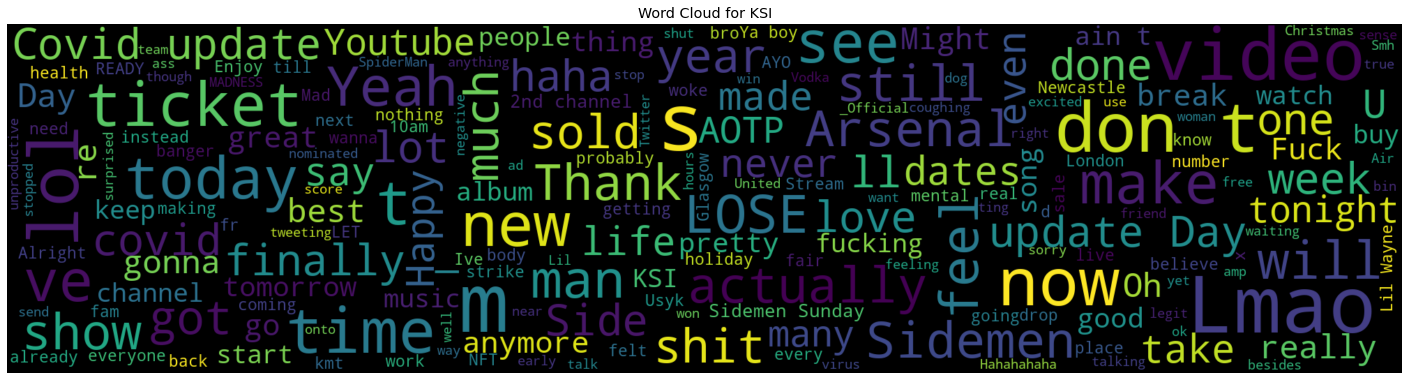

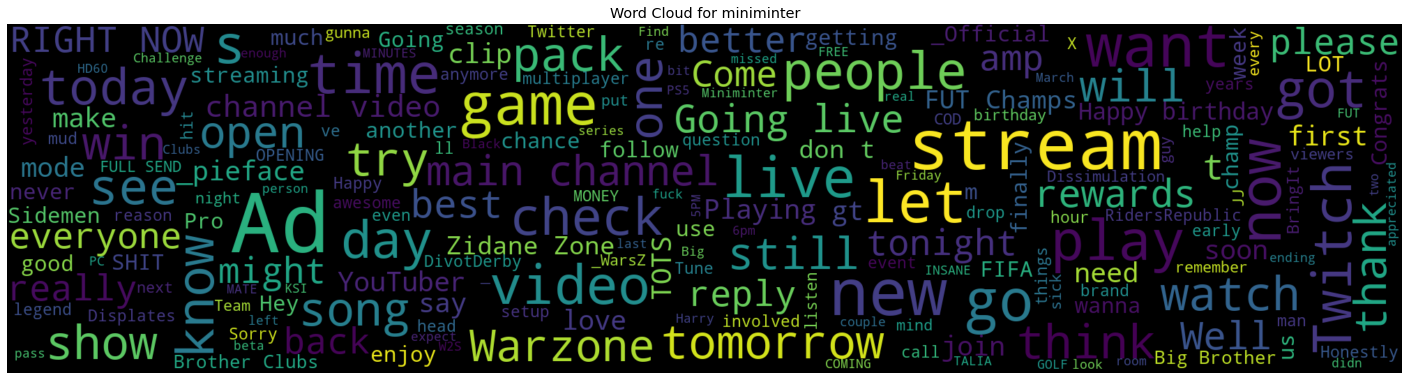

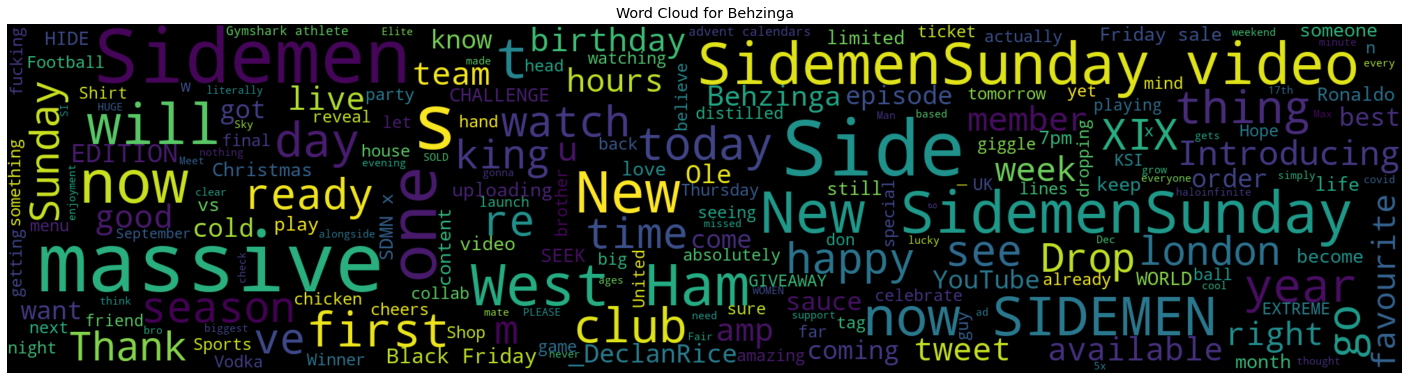

In [ ]:
def generate_word_clouds(names: list):
    """Generates word clouds based on most to least frequently used words in each user's tweets

    Args:
        names (list): list of users
    """
    print(df["user"].unique())
    for user in names:
        # Create temp dataframe containing this users tweet data
        tempdf = df[df["user"] == user]
        if tempdf.shape[0] == 0:
            print("doesn't work")
            continue
        # Retrieve each word from this users tweets
        allWords = " ".join([twts for twts in tempdf["tweets"]])
        plt.figure(figsize=graph_size)
        # Create a word cloud image using the words retrieved from tweet
        wordCloud = WordCloud(
            width=2000, height=500, random_state=21, max_font_size=119
        ).generate(allWords)
        plt.imshow(wordCloud, interpolation="bilinear")

        plt.title(f"Word Cloud for {user}")
        plt.axis("off")
        plt.show()


# Clean every tweet of irrelevant and common jargon - https, @, RT, etc.
df["tweets"] = [clean_tweet_data(element) for element in df["tweets"]]
# Create word cloud based on least to most frequenetly used words
generate_word_clouds(names)


# Task 3


In [ ]:
# def plot_likes_over_time():
#     users = ["KSI"]
#     df = read_twitter_data(users)
#     df
#     likes = []
#     create_times = []

#     for user in users:
#         temp = df[df["user"] == user]
#         temp = temp.astype({'likes': 'int32'})
#         temp['create_time']= pd.to_datetime(temp['create_time'])

#         create_list = temp["create_time"].tolist()
#         create_times.append(create_list)

#         like_list = temp["likes"].tolist()
#         likes.append(like_list)

#     dates_likes = list(zip(create_times, likes))
#     sorted_zipped_lists = sorted(dates_likes)
#     sorted_list1 = [element for _, element in sorted_zipped_lists]

#     print(sorted_list1)
#     # plt.plot(create_times, likes, label = "ye")
#     # plt.ylabel("")
#     plt.show()


# plot_likes_over_time()


In [93]:
def get_data_networkx_parameters(df):
    G = nx.from_pandas_edgelist(
        df, source="user", target="mention", create_using=nx.Graph()
    )
    # Visual layout
    pos = nx.kamada_kawai_layout(G)
    return G, pos


def print_edge_and_neighbours_list(G, sample_size = 10):
    edges = list(G.edges)[0:sample_size]
    neighbours = list(G.neighbors("KSI"))[0:sample_size]
    # Prints all edges
    print(f"[*]\tSample edge list of size: {sample_size}")
    print(*edges, sep="\n")
    print(f"[*]\tSample neighbour list for 'KSI' of size: {sample_size}")
    print(*neighbours, sep="\n")


def get_degree_distribution(G):
    print("[*]\tDegree Distribution")
    degrees = [G.degree(n) for n in G.nodes()]

    fig = go.Figure(
        data = go.Histogram(
                x=degrees,
                textposition="auto",
                name="Degree Distribution",
                showlegend=False,
            ),
        layout = go.Layout(
            title = dict(
                text = 'Degree Distribution',
                x = 0.5
            ),
            xaxis = dict(title = "Network Nodes"),
            yaxis = dict(title = "Frequency of Connections (log scale)", type = "log")
        )
    )
    fig.show()
    # plt.hist(degrees)
    # plt.show()


def get_clustering_coefficient(G):
    print("[*]\tClustering Coefficient")
    print(nx.clustering(G))


def get_betweenness_centrality(G):
    print("[*]\tBetweenness Centrality")
    print(nx.betweenness_centrality(G))


def get_assortativity(G):
    print("[*]\tAssortativity")
    print(nx.degree_assortativity_coefficient(G))


def get_edge_trace(G, pos):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines",
    )

    return edge_trace


def get_node_trace(G, pos):
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale="ylgn",
            reversescale=False,
            color=[],
            size=16,
            colorbar=dict(
                thickness=20,
                title="# User Mentions",
                xanchor="left",
                titleside="right",
            ),
            line_width=3,
        ),
    )
    return node_trace


def plot_user_mentions_network(G, pos, df):
    """Plot network of mentions from the tweets from users provided through names
    Args:
        names (list): list of user names
    """
    plt.figure(figsize=graph_size)
    plt.title(f"Mentions across {number_of_tweets} tweets per user account")
    plt.style.use("seaborn-notebook")
    plt.grid(b=None)
    # Takes G (The graph), pos (layout style) and alpha (transparency of each node) as parameter to draw network
    # print(df.shape[0])

    # Get total mention count for each user
    new_df = get_mention_counts(df)
    new_df["G"] = G
    # Ensures ordering of dataframe values correlate with order of G column values
    new_df = new_df[["G"]].merge(
        new_df[["mention", "count"]], left_on="G", right_on="mention"
    )

    node_sizes = new_df["count"]
    new_df["normalised"] = [result / 100 for result in node_sizes]

    scaler = MinMaxScaler()
    arr_scaled = scaler.fit_transform(new_df[["count"]])
    new_df["min_max_norm"] = arr_scaled

    min_node_alpha = 0.8
    min_node_size = 0.3

    alpha = [
        (
            min_node_alpha * (element < min_node_alpha)
            + (element * (element > min_node_alpha))
        )
        for element in new_df["min_max_norm"]
    ]
    colourmap = new_df["min_max_norm"]
    node_size = [
        4500
        * (
            min_node_size * (element < min_node_size)
            + (element * (element > min_node_size))
        )
        for element in new_df["min_max_norm"]
    ]

    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list("rg", ["green", "pink", "red"], N=256)
    nodes = nx.draw_networkx_nodes(
        G, pos, alpha=alpha, cmap="Set3", node_color=colourmap, node_size=node_size
    )
    nodes.set_edgecolor("gray")
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.3)
    plt.savefig(f"NetworkxGraph_{names}.png", format="PNG")


def plot_mentions_plotly_network(G, pos, df):
    """Plots mentions made by each main user using NetworkX and Plotly for visualisation

    Args:
        G (Graph): Represents the graph and it's attributes
        pos (list): list of every node's x and y coordinates (Dependent on the visual layout used)
        df (pd.DataFrame)): Dataframe we're reading twitter data from
    """
    # We need several overlaying plots
    # Scatter plot (Line mode) for edges
    edge_trace = get_edge_trace(G, pos)
    # Scatter plot (Marker mode) for nodes
    node_trace = get_node_trace(G, pos)

    node_adjacencies = []
    node_mentions = []
    node_text = []
    # Get dict of user mentions by each main user
    user_mentions = get_mention_count_per_user(df)
    for node, mentioned in enumerate(G.adjacency()):
        # Node connections
        node_adjacencies.append(len(mentioned[1]))
        text = ""
        # Don't append user connections for main users as it will spam text (too many users)
        # If the users mentioned aren't the main users
        if not any(user in mentioned[0] for user in names):
            # Create a string with all connections this user has
            mentions_and_counts = []
            mentions_ = []
            # For each main user who mentioned the user
            for key in mentioned[1].keys():
                # Append mention count to list
                mentions_.append(user_mentions[key][mentioned[0]])
                # Append main user and number of times main user mentioned this user
                mentions_and_counts.append([key, user_mentions[key][mentioned[0]]])
            node_mentions.append(sum(mentions_))
            # Format and create list of users who mentioned this user + mention counts
            text = text.join(
                f"{element[1]} mentions by {element[0]}<br>"
                for element in mentions_and_counts
            )
        else:
            node_mentions.append(-1)
        if text != "":
            text = "<br><b>Mention Quantity</b><br>" + text
        # Node user's name + no. connections
        node_text.append(
            f"<b>User: {list(G.nodes())[node]}</b><br>Connections: {str(len(mentioned[1]))}<br>Mentions: {node_mentions[node]}<br>{text}"
        )

    # node_trace.marker.color = node_adjacencies
    node_trace.marker.color = node_mentions
    node_trace.text = node_text

    # Names formatted for title
    n = " ".join(df["user"].unique())
    today = date.today()
    today = today.strftime("%d/%m/%Y")
    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            autosize=False,
            width=800,
            height=600,
            title={
                "text": f"Twitter user mentions for : {n}",
                "y": 0.95,  # new
                "x": 0.5,
                "xanchor": "center",
                "yanchor": "top",  # new
            },
            titlefont_size=24,
            showlegend=False,
            hovermode="closest",
            # margin=dict(b=100, l=100, r=100, t=100),
            margin=dict(b=50, l=20, r=200, t=100),
            annotations=[
                dict(
                    text=f"<b>{mentions} mentions per user on {today}</b>",
                    showarrow=False,
                    xref="paper",
                    yref="paper",
                    x=0.005,
                    y=-0.05,
                )
            ],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            # paper_bgcolor='rgb(200,200,200)', # transparent background
            paper_bgcolor="rgb(220,220,220)",  # transparent background
            plot_bgcolor="rgb(220,220,220)",  # transparent 2nd background
        ),
    )

    fig.show()


mentions = 50
# Read data and clean
df = read_twitter_data(names)
df = filter_dataframe_for_mentions(df)
df = standardise_mentions(df)
df = expand_multiple_mentions(df)
df = condense_dataframe_add_user_count(df)
# Prepares data for graph
G, pos = get_data_networkx_parameters(df)

print_edge_and_neighbours_list(G)
get_degree_distribution(G)
get_clustering_coefficient(G)
get_betweenness_centrality(G)
get_assortativity(G)
plot_mentions_plotly_network(G, pos, df)


[*]	Sample edge list of size: 10
('KSI', 'r9rai')
('KSI', 'eatsides')
('KSI', 'm4vric_')
('KSI', 'mrbeast')
('KSI', 'jdofficial')
('KSI', 'beersrichards')
('KSI', 'bbcr1')
('KSI', 'ksistatistics')
('KSI', 'cobie')
('KSI', 'geenelly')
[*]	Sample neighbour list for 'KSI' of size: 10
r9rai
eatsides
m4vric_
mrbeast
jdofficial
beersrichards
bbcr1
ksistatistics
cobie
geenelly
[*]	Degree Distribution


[*]	Clustering Coefficient
{'KSI': 0, 'r9rai': 0, 'eatsides': 0, 'm4vric_': 0, 'mrbeast': 0, 'jdofficial': 0, 'beersrichards': 0, 'bbcr1': 0, 'ksistatistics': 0, 'cobie': 0, 'geenelly': 0, 'charlierwarner': 0, 'aleks_fut': 0, 'sidemenupdated': 0, 'annemarie': 0, 'kirstielouisee': 0, 'hitsradiouk': 0, 'chipfat_': 0, 'calfreezy': 0, 'melvinodoom': 0, 'migaladari': 0, 'xixvodka': 0, 'sidemen': 0, 'mtvema': 0, 'mtvuk': 0, 'mtv': 0, 'tubbolive': 0, 'ray33k1': 0, 'nathandawe': 0, 'nortfx': 0, 'kazooie94': 0, 'talkinboutliz': 0, 'loganpaul': 0, 'quackity': 0, 'syndrome22q1': 0, 'syndicate': 0, 'abdulovesyou': 0, 'rickyberwick': 0, 'adidasoriginals': 0, 'master_ov': 0, 'manny_official': 0, 'stephentries': 0, 'xansmind': 0, 'dhardayal': 0, 'benjy1990': 0, 'newtoncreations': 0, 'eshaanakbar': 0, 'sneerid': 0, 'yatochnoznau': 0, 'thafnine': 0, 'emmalou25': 0, 'miniminter': 0, 'taliamar': 0, 'zerkaahd': 0, 'pgatour2k': 0, 'ridersrepublic': 0, 'vikkstar123': 0, 'behzinga': 0, 'scufgaming': 0, 'cras